In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

***Techniques used:***
- Data Normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight decay
- Gradient clipping
- Adam optimizer

In [ ]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['train', 'test']
['truck', 'airplane', 'horse', 'bird', 'ship', 'dog', 'frog', 'deer', 'cat', 'automobile']


#Channelwise normalization & Randomized data augmentation

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 400

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
    break

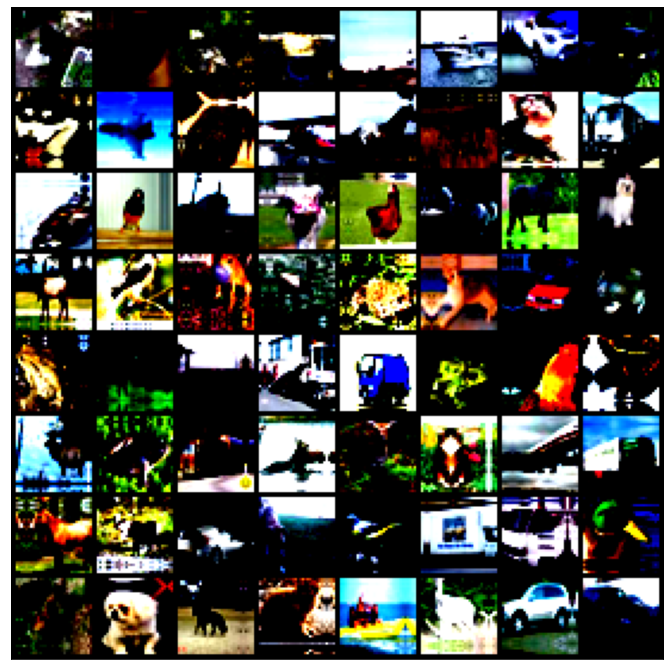

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Model with Residual blocks and batch normalization

In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + xb

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [ ]:
def accuracy(out, targets):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
class ClassificationBase(nn.Module):
  def training_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    return loss

  def validation_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    acc = accuracy(out, targets)
    return {'loss': loss, 'acc': acc}

  def validation_epoch_end(self, res):
    losses = [x['loss'] for x in res]
    loss = torch.stack(losses).mean()
    accs = [x['acc'] for x in res]
    acc = torch.stack(accs).mean()
    return {'loss': loss.item(), 'acc': acc.item()}

  def epoch_end(self, epoch, res):
    print(f'Epoch: [{epoch}], last_lr: [{res["lrs"][-1]}] Train loss: [{res["train_loss"]}], Valid loss: [{res["loss"]}], Valid acc: [{res["acc"]}]')

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)      # 64 x 32 x 32
    self.conv2 = conv_block(64, 128, pool=True)   # 128 x 16 x 16
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16

    self.conv3 = conv_block(128, 256, pool=True)  # 256 x 8 x 8
    self.conv4 = conv_block(256, 512, pool=True)  # 512 x 4 x 4
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4

    self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                    nn.Flatten(),    # 512
                                    nn.Linear(512, num_classes)) # 10

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, dl):
  model.eval()
  res = [model.validation_step(batch) for batch in dl]
  return model.validation_epoch_end(res)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))

  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record & update lr
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    res = evaluate(model, val_dl)
    res['train_loss'] = torch.stack(train_losses).mean().item()
    res['lrs'] = lrs
    model.epoch_end(epoch, res)
    history.append(res)
  return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'acc': 0.10170000046491623, 'loss': 2.3027994632720947}]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch: [0], Train loss: [1.345143437385559], Valid loss: [1.2994632720947266], Valid acc: [0.5954999327659607]
Epoch: [1], Train loss: [1.0414440631866455], Valid loss: [0.977483868598938], Valid acc: [0.6821000576019287]
Epoch: [2], Train loss: [0.827587902545929], Valid loss: [0.6088001132011414], Valid acc: [0.7930000424385071]
Epoch: [3], Train loss: [0.5878394842147827], Valid loss: [0.726181149482727], Valid acc: [0.7581000328063965]
Epoch: [4], Train loss: [0.46382778882980347], Valid loss: [0.546931803226471], Valid acc: [0.8206999897956848]
Epoch: [5], Train loss: [0.3523927927017212], Valid loss: [0.3870149850845337], Valid acc: [0.8696000576019287]
Epoch: [6], Train loss: [0.2556307911872864], Valid loss: [0.2947963774204254], Valid acc: [0.898400068283081]
Epoch: [7], Train loss: [0.18791602551937103], Valid loss: [0.27895957231521606], Valid acc: [0.9061000347137451]
CPU times: user 31.2 s, sys: 7.64 s, total: 38.9 s
Wall time: 4min 15s


In [ ]:
def plot_accs(history):
  accs = [x['acc'] for x in history]
  plt.figure(figsize=(20, 8))
  plt.plot(accs, '-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy score')
  plt.title('Model accuracy x Epoch N.');

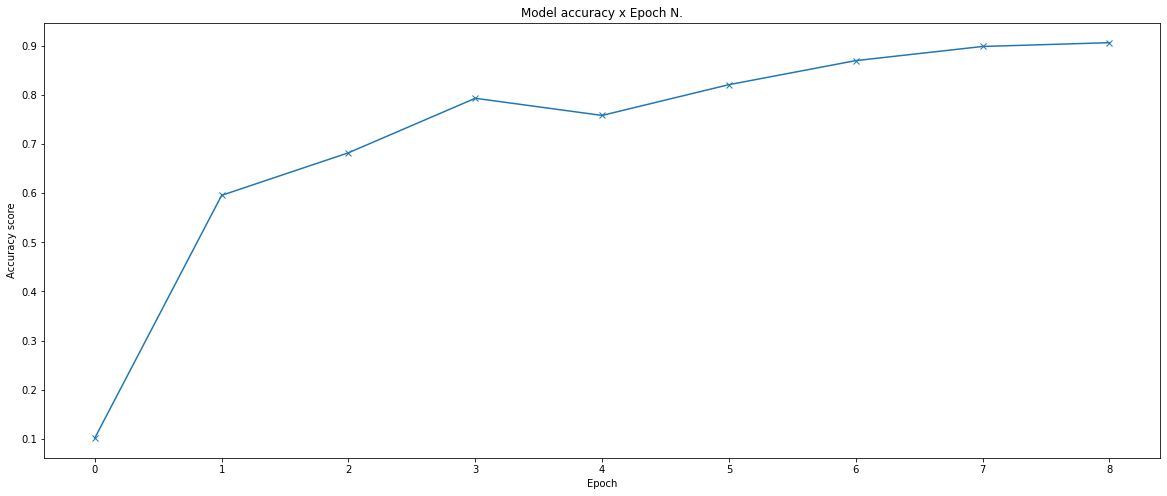

In [ ]:
plot_accs(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['loss'] for x in history]
  plt.figure(figsize=(20, 8))
  plt.plot(train_losses, label='Train')
  plt.plot(val_losses, '-x', label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy score')
  plt.title('Loss x Epoch N.')
  plt.legend();

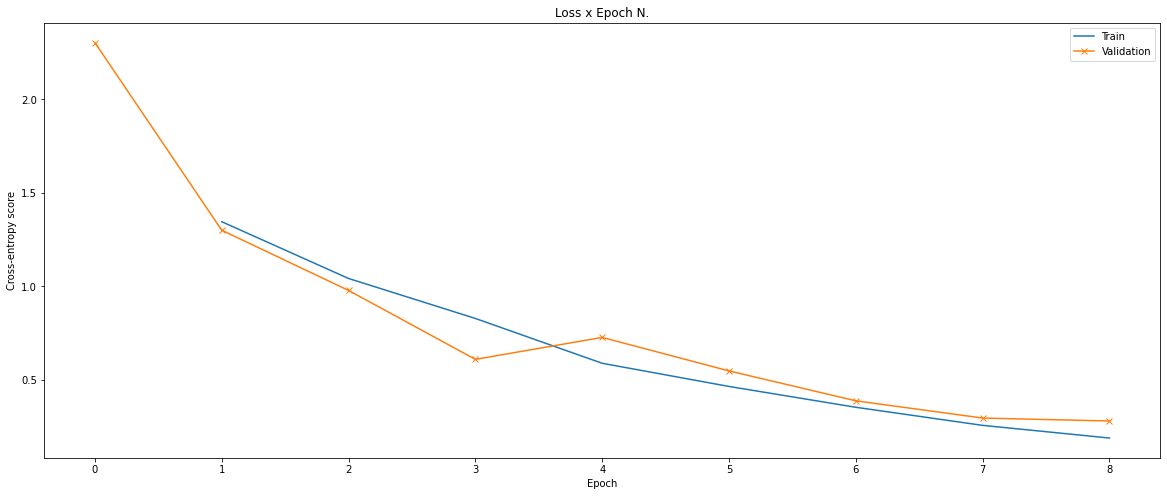

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.figure(figsize=(20, 8))
  plt.plot(lrs)
  plt.xlabel('Batch')
  plt.ylabel('Learning rate')
  plt.title('Learning rate x Batch N.');

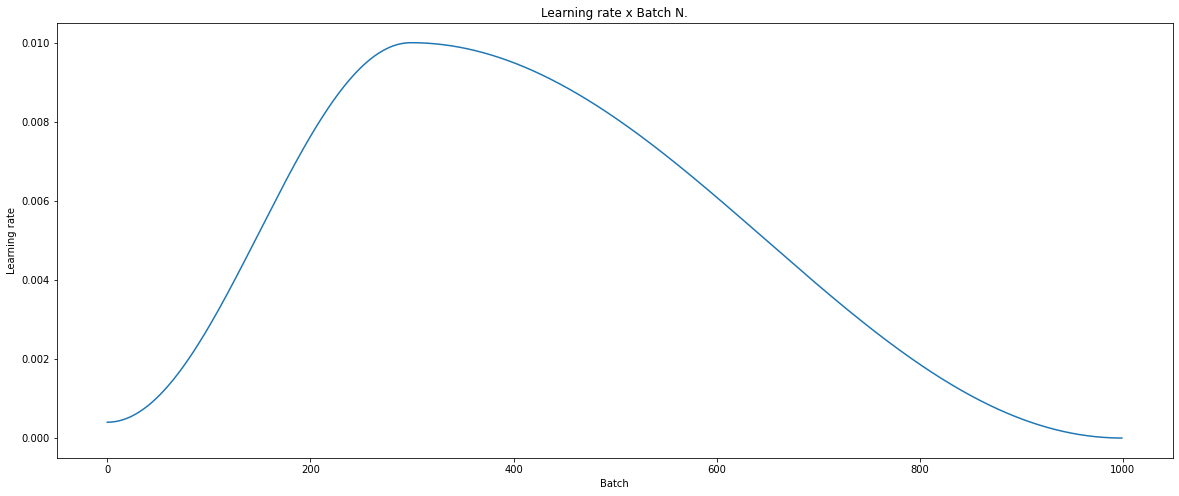

In [ ]:
plot_lrs(history)